# No One Likes A Crowded Gym

That is why I created this project.  Since my gym tweets out how many people are in the weight room at a given time, and has been doing this for years, I figured I could use some machine learning to tell me when to avoid the gym and help me plan my workouts.

# The Data

The data are mined from my gym's twitter account.  Shown below is a typical tweet.

![A Typical Tweet](TypicalTweet.png)


The "WR" is the weight room.  That is what I am interested in predicting.  I've automated the scraping with some functions in this repo.  Let's do the scraping.

(Note, in order to do the scraping, you will need a set of twitter API keys and a set of forecastio API keys).

In [1]:
from tools import update_tweet_db

update_tweet_db() #That's it!

The database is now up to date with the most recent tweets.  I won't get into how I manage to infer the number of people in the weight room.  It is just some simple heuristics since the tweets are relatively consistent in format.

I also capture weather information for each day.  I've noticed the gym is less busy on really hot days and really rainy days.  Let's extract all the data I have collected and make some plots.

In [2]:
from tools import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

X,y = fetch_training() #X are covariates, y are weight room numbers.

X['WR'] = y

X.head()

,created_at,apparentTemperature,humidity,precipIntensity,precipProbability,precipType,pressure,visibility,windBearing,windSpeed,WR
0,2014-01-03 09:30:28,-20.78,0.76,0.2489,0.90,snow,1029.19,16.08,300.0,4.51,18.0
1,2014-01-03 10:13:43,-17.87,0.63,0.0381,0.05,snow,1029.87,16.08,271.0,3.15,20.0
2,2014-01-03 12:19:32,-16.14,0.59,0.0102,0.02,snow,1029.86,16.08,111.0,3.01,34.0
3,2014-01-03 12:44:04,-16.14,0.59,0.0102,0.02,snow,1029.86,16.08,111.0,3.01,41.0
4,2014-01-03 13:09:38,-20.24,0.60,0.0102,0.02,snow,1029.66,16.08,220.0,10.91,43.0


Here is all the information I collect:  The tweet's timestamp, some measurements on temperature, precipitation, and of course the weight room numbers.  

Let's visualize all the days I have in the database by year. The `created_at` column is not useful to us right now.  We need to do some feature engineering to get some more useful time features.  I've written a `TimeFeatureExtractor` to make this process a little easier.

In [3]:
from tools.transforms import *
time_extractor = TimeFeatureExtractor()
time_features = time_extractor.fit_transform(X['created_at'])
X = X.merge(time_features, left_index=True, right_index=True)



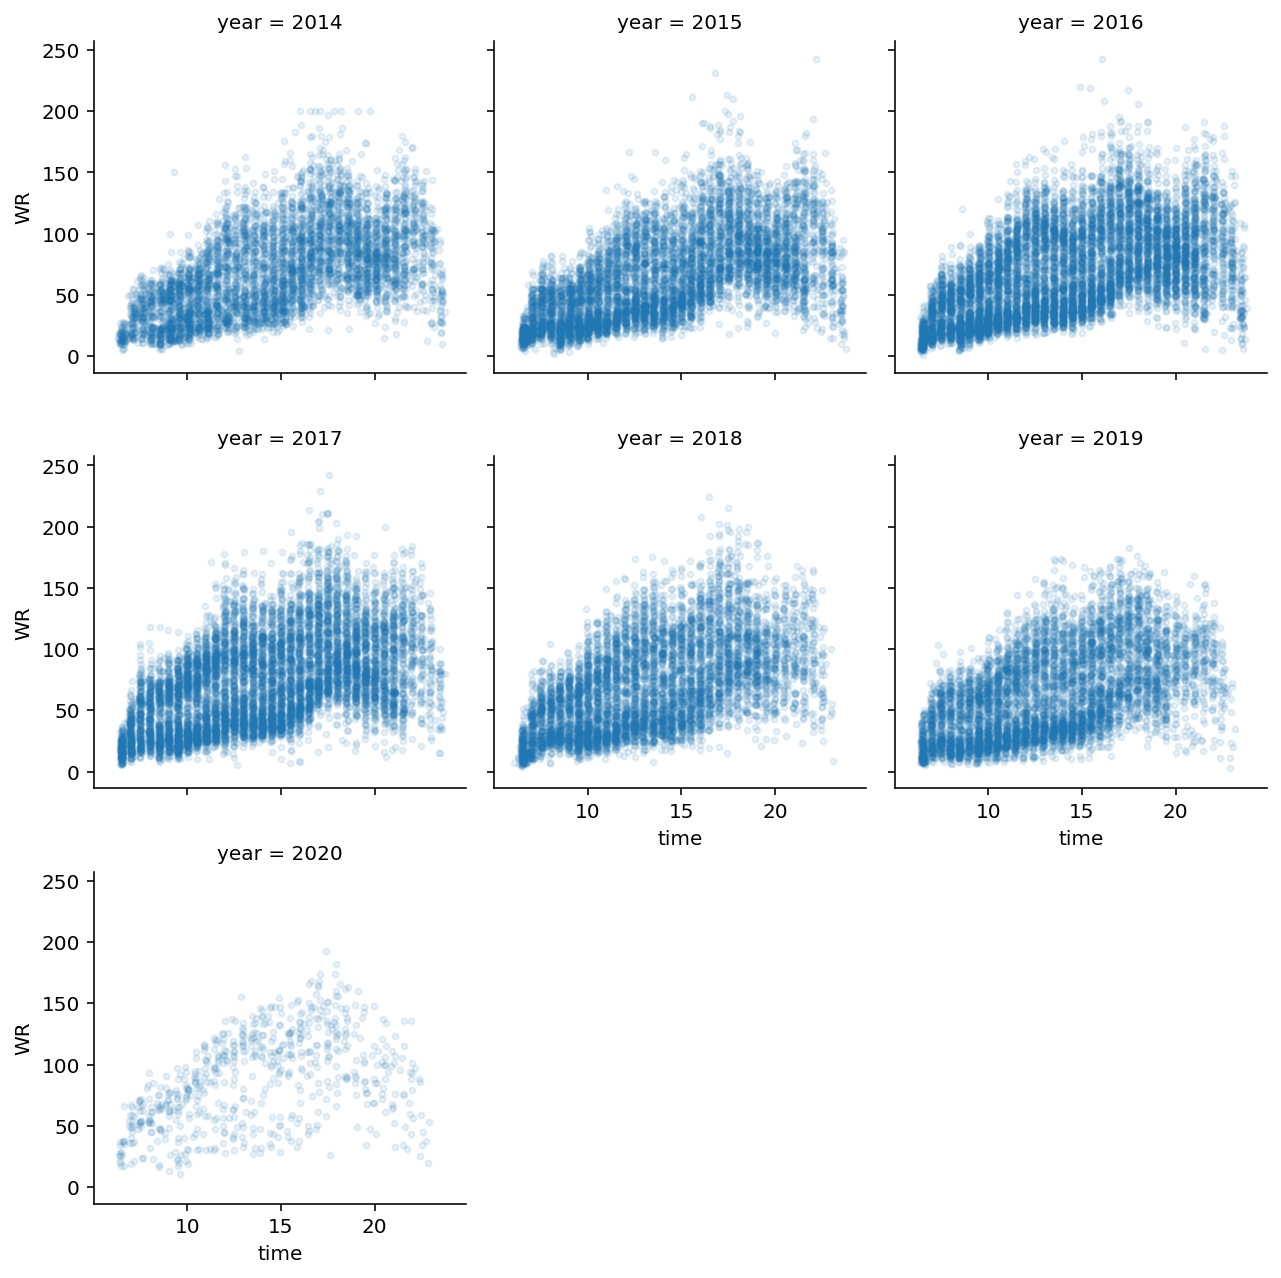

In [4]:
g = sns.FacetGrid(data = X, col='year', col_wrap=3)

g.map(plt.scatter, 'time','WR', alpha = 0.1, marker = '.')

Immediately we see there are considerable increases in weight room numbers between 3pm and 8pm (15 and 20 respectively on the x axes of these plots). That is unsurprising. It looks like the best time to go to the gym is in the morning because there are fewer people.  This is also unsurprising. What is surprising is that the worst time to go to the gym changes as semesters go on.  I'll show you what I mean.

Take a look below.  In Setpember, the worst time (i.e. the busiest) is between 3 and 8, with peaks around 4 or 5.  You might think that you can avoid crowds by going 9 or 10 at night.  That strategy works well in September, but as October and Novemerb roll around, the busiest time is actually around 9 or 10! 

This leads to a nice rule of thumb for going to the gym:  **The best time to work out is in the morning.  If you can't go in the morning, go late at night in September and as early as possible in October through December.**

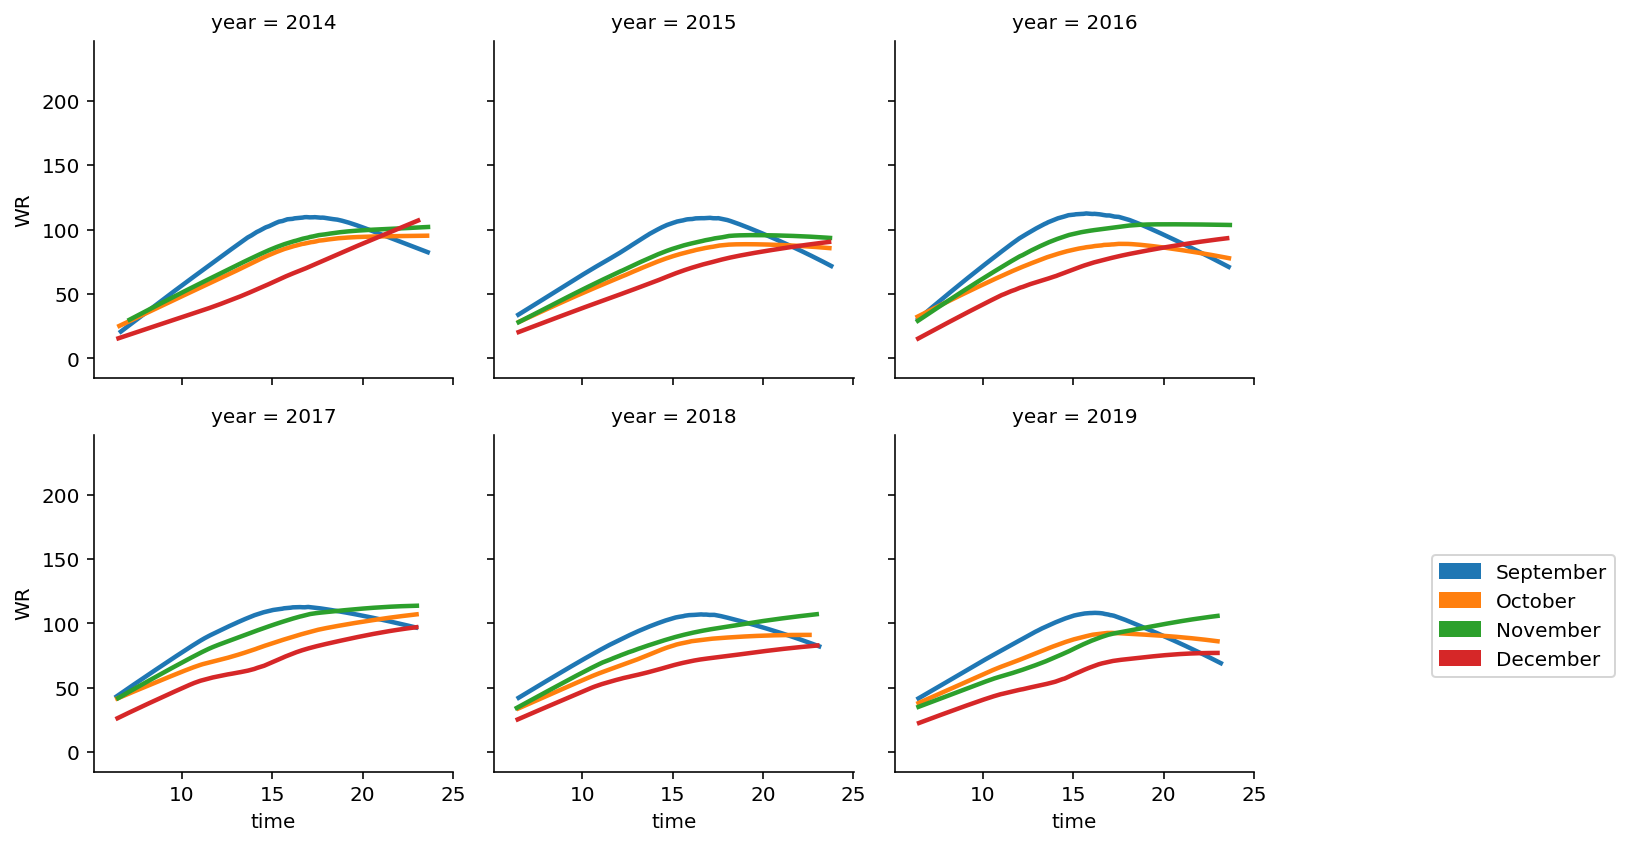

In [5]:
worst_time_data = X.query('month>=9').copy()
worst_time_data['month_name'] = worst_time_data.created_at.dt.month_name()


g = sns.FacetGrid(data = worst_time_data, col='year',hue='month_name', col_wrap=3)

g.map(sns.regplot, 'time','WR', scatter_kws = {'alpha':0}, lowess = True)

handles = [patches.Patch(color = 'C0', label = 'September'),
          patches.Patch(color = 'C1', label = 'October'),
          patches.Patch(color = 'C2', label = 'November'),
          patches.Patch(color = 'C3', label = 'December')]

plt.legend(handles = handles, loc = 'lower center', bbox_to_anchor = (1.75, 0.25))

# Machine Learning

There is a lot of EDA to do with this data, but I am more interested in predicting gym usage from this data. 

If you're reading this, I don't need to give you a primer on machine learning, so I'll cut right to it.  I've written a pipeline to do all the feature engineering and model train and use a walk forward cross validation scheme to estimate out of sample performance.  Python's `scikit-learn` has a time series cross validation scheme, but since I have so much data (approx. 5 years worth at the time of writing this) I am just going to use each year as a fold.  

The model is trained using the `make_pipeline()` function.  This will perform the cross validation and save the model.  We can load the model using `load_model()`.  The workflow is pretty easy after that.

/Users/demetri/miniconda3/envs/gymbo/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


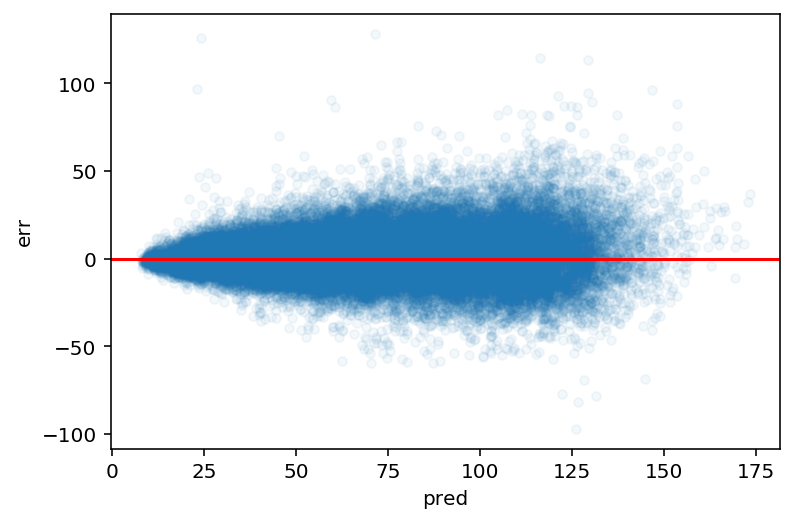

In [6]:
model = load_model()

X,y= fetch_training()

X['pred'] = model.predict(X)
X['WR'] = y
X['err'] = X.WR - X.pred

ax = X.plot.scatter('pred','err', alpha = 0.05)
ax.axhline(0, color = 'red')

You can see that the predictions are clustered around 0, which is good.  

# Knowledge Mobilization

It is one thing to make a machine learning model, it is another to make that model useful.  I've also written some functions to extract data from today, plot that data, and tweet the plot from a dedicated twitter account.  Take a peek below.

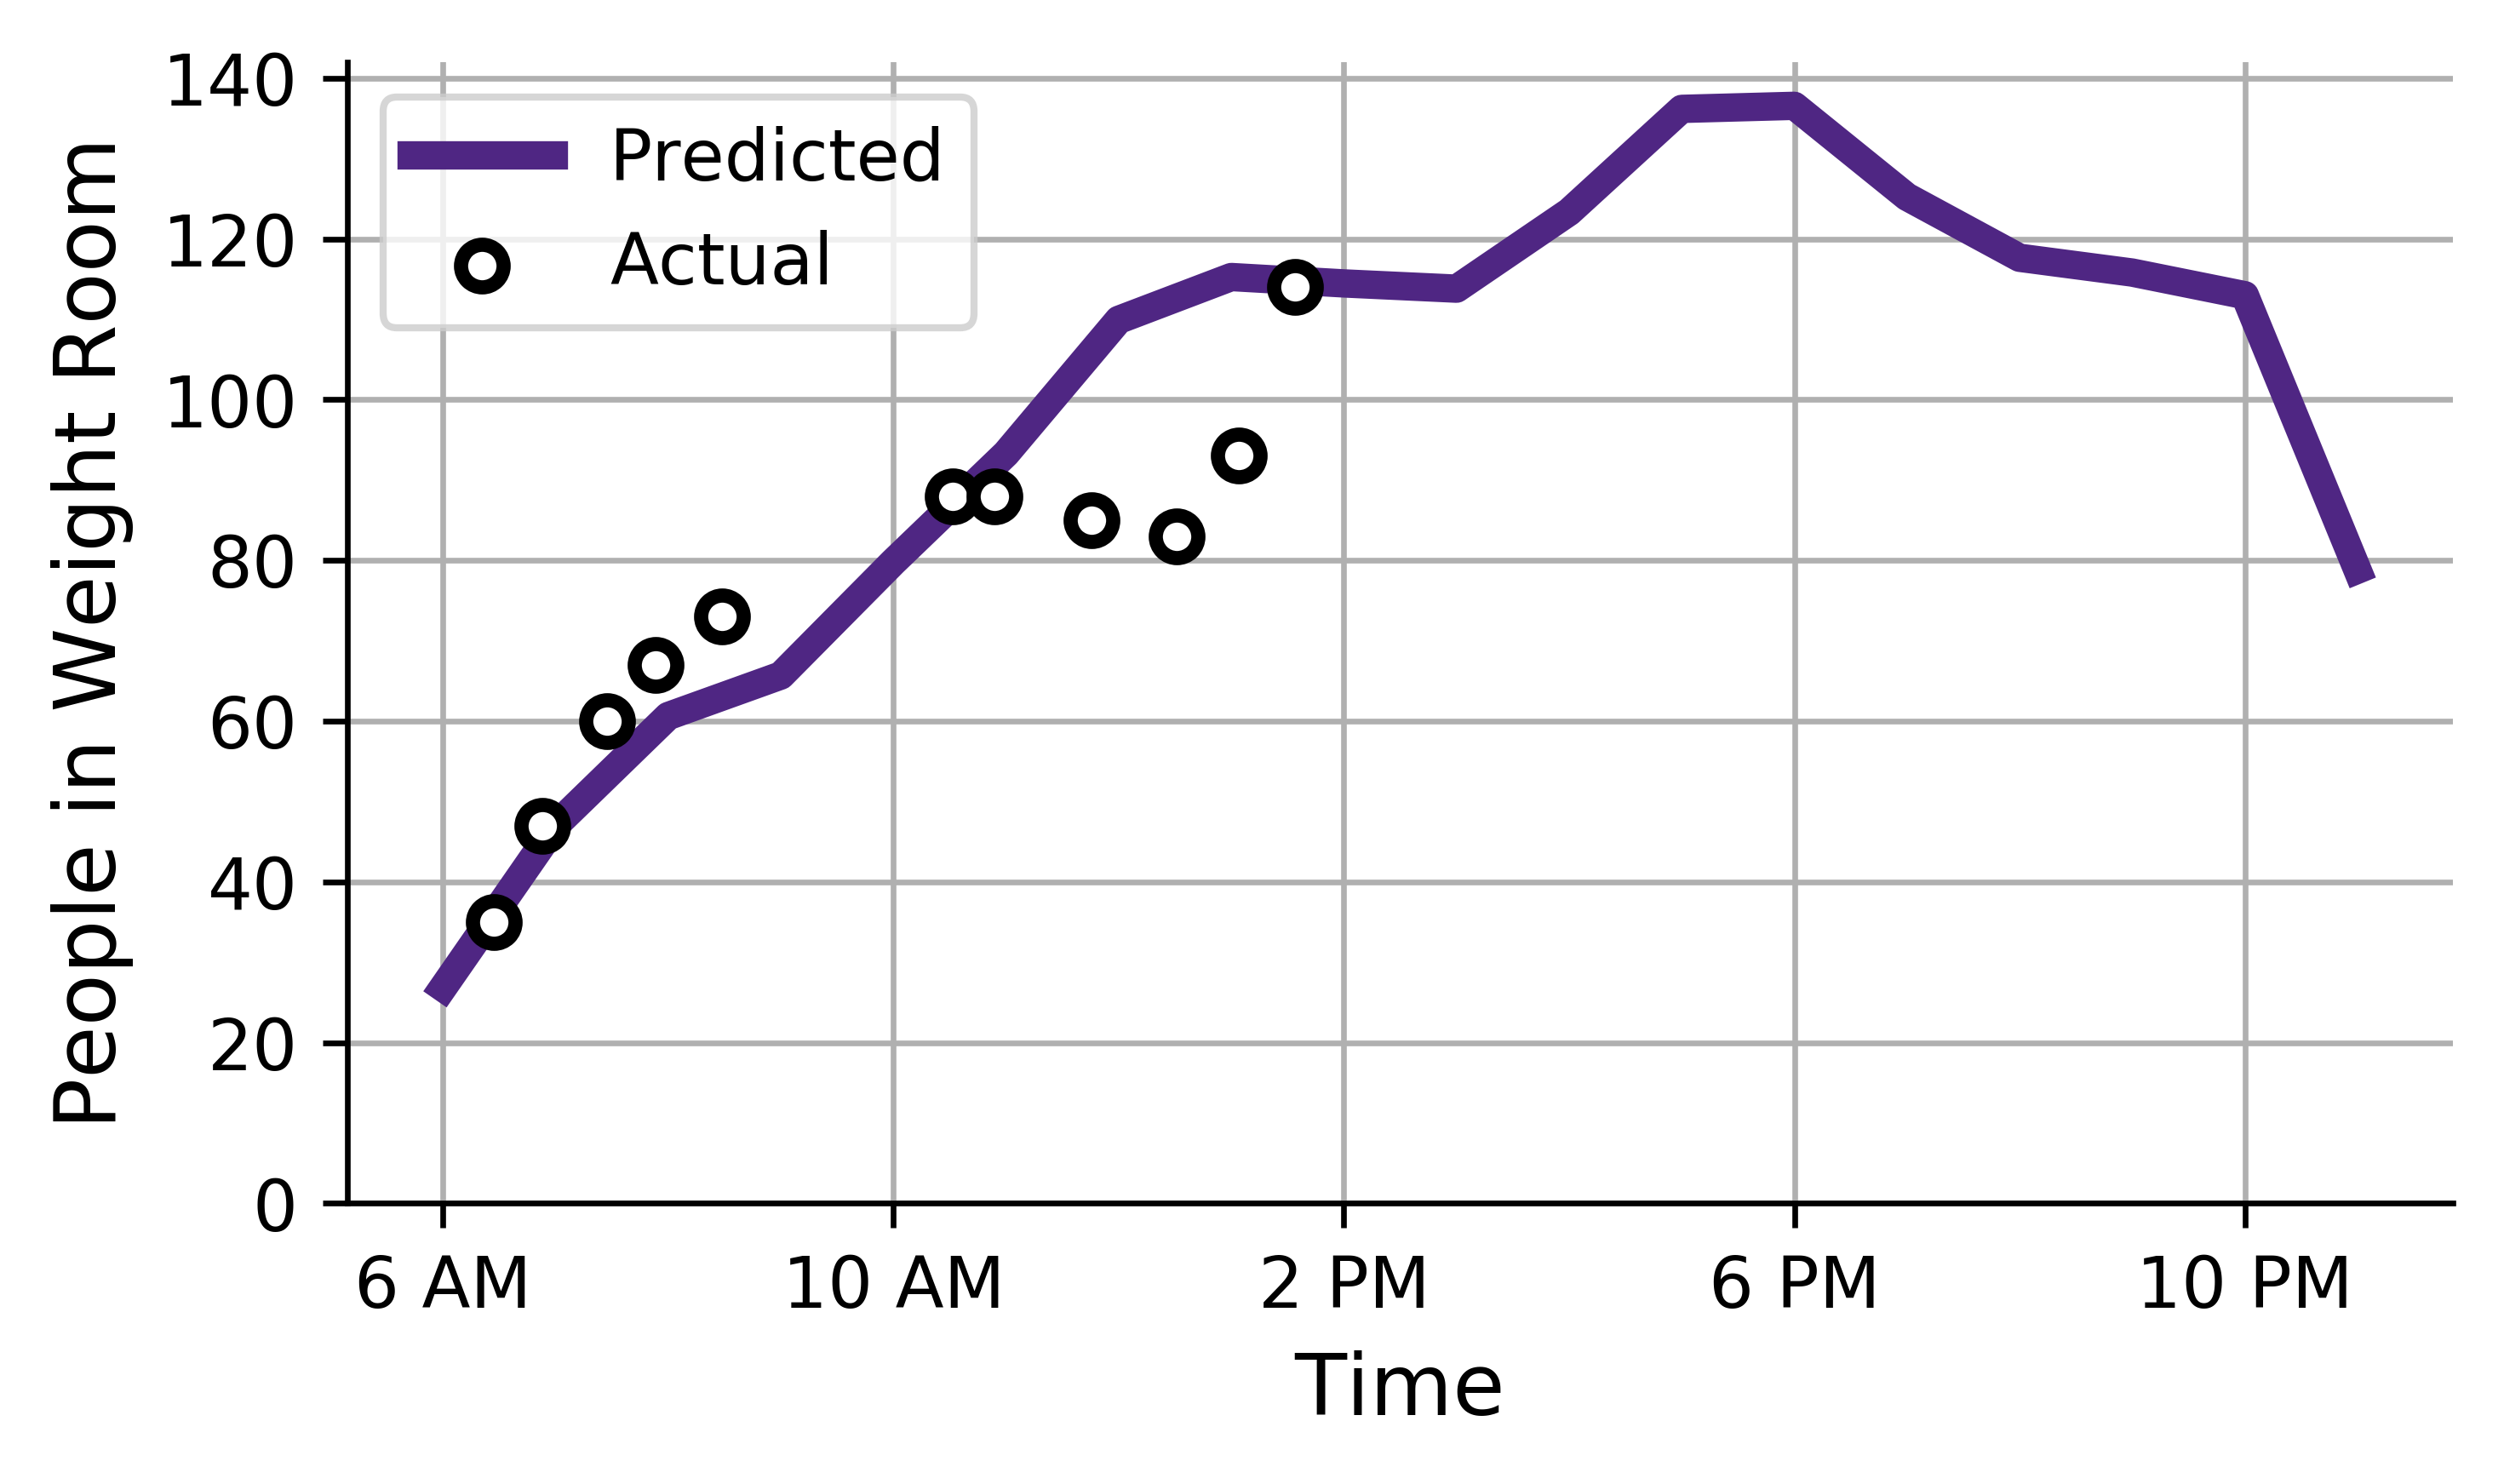

In [7]:
preds = fetch_weather() #Function to grab weather and time.  That is all we need to make a prediction
preds['pred'] = model.predict(preds) #Pass it right into the model!  Yay feature engineering pipelines!
preds.head()

wr = fetch_wr() #Grab actual weight room numbers to comapre predictions to

make_plot(preds,wr)

# Conclusion

This is a pretty fun little project.  The model is just OK.  The observations are obviously correlated, so I would actually like to turn it into a GP.  More to come...eventually.